In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  6 22:27:45 2023

@author:
"""

import numpy as np
import math
import matplotlib.pyplot as plt
import array
import fractions    

def Adv_x(i,j):
    return (1/h) * ( ((u[i+1,j]+ u[i,j])/2)**2 - ((u[i,j] + u[i-1,j])/2)**2 )

def Dif_x(i,j):
    return (1/h**2) * (u[i+1,j]+u[i-1,j]+u[i,j+1]+u[i,j-1] - 4*u[i,j])

def anal(y):
    return -187.5*y**2 + 0.01875

def levelset (x,y):
    return radius - math.sqrt( (x-xd)**2 + (y - yd)**2 )  

def heavy (phi, M):
    if phi< -M*h:
        return 0
    elif abs(phi) <= M*h:
        return 0.5 * (1+phi/(M*h) + (1/math.pi)*math.sin(math.pi*phi/(M*h)))  
    elif phi > M*h:
        return 1
    
def L (u, phi_plus, phi_minus):  # Recall this is the ad hoc method
    return -u*(phi_plus - phi_minus)/(h)

 

In [2]:
       
# constants 
M = 3
nu = 1e-6
mul = 1e-3
mug = 1e-5
rhol = 1e3
rhog = 1
gradP = -0.375
max_vel = 0.01875 # this is the max velocity of the analytical solution

# building the domain
L1 = 0.04 # x
L2 = 0.02 # y
Ny = 50
Nx = int(Ny*2) 
h = L1/Nx

# Set up CFL and dt
cfl = 0.999
dt = cfl*h/max_vel

#droplet info
radius = L2/4
r_dpl=radius
xd = 0
yd = 0

#Initialize the property grids
phi = np.zeros([Nx+2,Ny])
phi_star = np.zeros([Nx+2,Ny])
phi_n1 = np.zeros([Nx+2,Ny])
rho = np.zeros([Nx+2,Ny])
mu = np.zeros([Nx+2,Ny])
xlist = np.linspace(-L1/2,L1/2,Nx+2)
ylist = np.linspace(-L2/2,L2/2, Ny)   # we crop out two rows of nodes because those are the ghost nodes that give us no slip BC

#xi=np.round(inter_polator(hig_x,var_dict),4)
#xj=np.round(inter_polator(hig_y,var_dict),4)


grid_x = np.zeros([len(xlist),len(ylist)]) 
grid_y = np.zeros([len(xlist), len(ylist)])
D_plus_grid = np.zeros([len(xlist), len(ylist)])
D_minus_grid = np.zeros([len(xlist), len(ylist)])

#Now let's build an analytical velocity grid, then define a discretized analytical velocity profile
u = np.zeros([len(xlist), len(ylist)])
analist= np.linspace(-L2/2,L2/2,Ny)
for i in range(0, len(xlist)):
    for j in range(0, len(ylist)):
        u[i,j] = anal(analist[j])

#Now let's set up constant grids that will be out of the advection for loop
for i in range(0,len(xlist)):
    for j in range(0,len(ylist)):
        grid_y[i,:] = ylist
        grid_x[:,j] = xlist
        phi[i,j] = levelset(grid_x[i,j], grid_y[i,j])  #Now fill up phi, which in 7a was called level_set_field
        
# Okay big dog, from here on out everything will advected and updated
dt=0.001

In [ ]:
iteration

In [ ]:
fig, ax=plt.subplots(figsize=(10, 5))
plt.contourf(grid_x, grid_y, np.where(phi<0,0,phi), 15, cmap='viridis')
#ax.add_patch(plt.Circle((0, 0), radius=r_dpl, color='black', fill=False))
plt.plot(0+0.008, 0, marker="o", markersize=5, markeredgecolor="white", markerfacecolor="black")
plt.colorbar()
plt.xlabel('$x1$ (m)')
plt.ylabel('$x2$ (m)')
plt.title(f"Advecting Level_set field with black dot representing 20% domain length")
plt.gca().set_aspect('equal')
plt.show()

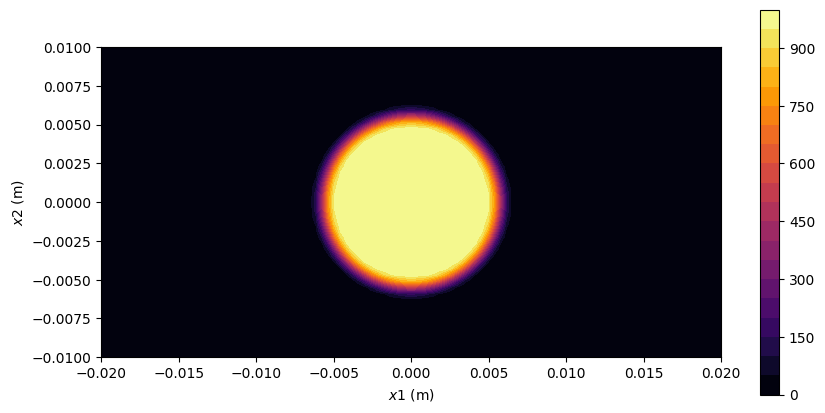

In [4]:
fig, ax=plt.subplots(figsize=(10, 5))
plt.contourf(grid_x, grid_y, rho, 20, cmap='inferno')
#ax.add_patch(plt.Circle((0, 0), radius=r_dpl, color='black', fill=False))
plt.colorbar()
plt.xlabel('$x1$ (m)')
plt.ylabel('$x2$ (m)')
#plt.title('domain $u$ contour ($m/s$)')
plt.gca().set_aspect('equal')
plt.show()

In [3]:

for iteration in range(0,2):
    for i in range(0,len(xlist)):
        for j in range(0,len(ylist)):
            rho[i,j] = rhol*heavy(phi[i,j], M) + rhog*(1-heavy(phi[i,j], M))
            mu[i,j]  = mul*heavy(phi[i,j], M) + mug*(1-heavy(phi[i,j], M))

            if i < len(xlist)-1:
                phi_star[i,j] = phi[i,j] + dt * L(u[i,j], phi[i+1,j],phi[i-1,j])
            else:
                phi_star[i,j] = phi[i,j] + dt * L(u[i,j], phi[0,j],phi[i-1,j])
     
    # Do the corrector step for level set field advection
    for i in range(0,len(xlist)):
        for j in range(0,len(ylist)):
            phi_n1[i,j] = phi[i,j] + dt/2 * (L(u[i,j],  phi[0,j], phi[i-1,j]) + L(u[i,j],  phi_star[0,j], phi_star[i-1,j]))
            
    # figure, axes = plt.subplots()
    # plt.contourf(grid_x, grid_y, phi, 10, cmap= 'gray')
    # plt.title('Level Set Field when Ny = 50 \n timestep = %i' % iteration) 
    # legend=plt.colorbar() 
    # legend.ax.set_title('distance from interface',fontsize=8) 
    # plt.xlabel('X') 
    # plt.ylabel('Y') 
    # #interface = plt.Circle((xd, yd), radius, color ='red', fill = False)
    # #axes.add_artist(interface)
    # plt.show()        

    # now update the level set field
    phi = phi_n1


In [ ]:
ax = plt.figure(figsize=(20, 10)).add_subplot(projection='3d')
# Plot the 3D surface
#ax.plot_surface(grid_x, grid_y, np.where(phi<0,0,phi), edgecolor='black')
#ax.contourf(xi, xj, phin, zdir='y', offset=0.004, cmap='coolwarm')
#ax.contourf(xi, xj, phin, zdir='z', cmap='coolwarm')
#ax.contourf(xi, xj, drop_elem, zdir='z', cmap='inferno')
#ax.contourf(xi, xj, phin, zdir='z',offset=np.max(phin-phin_int), cmap='coolwarm')
ax.contourf(grid_x, grid_y, np.where(phi<0,0,phi), zdir='z', cmap='coolwarm')
#ax.contourf(xi, xj, phi_diff, zdir='y', cmap='coolwarm')
#ax.set(xlim=(-0.02, 0.02), ylim=(-0.01, 0.01),xlabel='X', ylabel='Y', zlabel='Z')

#ax.scatter(xi, xj, zs=drop_elem_int, zdir='z', c='g', label='points in (x, y)')
#ax.scatter(xi, xj, zs=drop_elem, zdir='z', c='r', label='points in (x, z)')
ax.set(xlim=(-0.02, 0.02), ylim=(-0.01, 0.01),xlabel='X', ylabel='Y', zlabel='Phi')
ax.view_init(azim=-45, roll=0)
ax.set_title('Projection of droplet Level Set field on xy plane')
plt.show()